# Import

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Data exploring

In [3]:
#data exploring
df = pd.read_csv('DATI.csv')

df

,timestamp,accX,accY,accZ,gyroX,gyroY,gyroZ,Label
0,1.732189e+09,-5.527879,-4.858718,-2.166334,-0.966667,-3.166667,-0.966667,"['sotto', 'fermo', 'fermo', 'fermo', 'sinistra..."
1,1.732189e+09,-5.200716,-5.413599,-2.259820,-0.366667,-2.866667,-1.400000,"['sotto', 'indietro', 'fermo', 'fermo', 'sinis..."
2,1.732189e+09,-3.524709,-5.594171,-1.247677,0.600000,-1.800000,-2.133333,"['fermo', 'indietro', 'fermo', 'fermo', 'sinis..."
3,1.732189e+09,-0.023709,-6.387939,1.155626,0.833333,-0.166667,-2.433333,"['fermo', 'indietro', 'fermo', 'fermo', 'fermo..."
4,1.732189e+09,2.153291,-6.756805,2.129320,0.600000,1.000000,-2.400000,"['fermo', 'indietro', 'fermo', 'fermo', 'fermo..."
...,...,...,...,...,...,...,...,...
40379,1.732189e+09,6.151457,-13.349115,13.103255,2.633333,2.133333,0.666667,"['sopra', 'indietro', 'destra', 'sinistra brac..."
40380,1.732189e+09,3.876457,-8.463914,11.822385,1.733333,0.833333,0.333333,"['fermo', 'indietro', 'destra', 'sinistra brac..."
40381,1.732189e+09,2.689457,-6.649928,11.716661,1.266667,0.133333,0.300000,"['fermo', 'indietro', 'destra', 'sinistra brac..."
40382,1.732189e+09,0.434457,-7.581928,12.356489,-0.266667,-0.066667,0.533333,"['fermo', 'indietro', 'destra', 'fermo', 'ferm..."


# Data cleaning

In [4]:
# rimuoviamo le label in eccesso tenendo solo le prime 3 righe
def trova_terza(str):
    for _ in range(3):
        idx = str.rfind(',')
        str = str[:idx]
    str = str + ']'
    print(str)

    return str

In [5]:
df['Label'] = df['Label'].apply(trova_terza)

['sotto', 'fermo', 'fermo']
['sotto', 'indietro', 'fermo']
['fermo', 'indietro', 'fermo']
['fermo', 'indietro', 'fermo']
['fermo', 'indietro', 'fermo']
['sopra', 'indietro', 'fermo']
['sopra', 'indietro', 'fermo']
['sopra', 'fermo', 'fermo']
['sopra', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'indietro', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'indietro', 'fermo']
['fermo', 'indietro', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'fermo', 'fermo']
['fermo', 'indietro', 'fermo']
['fermo', 'indietr

# aggregamento dati

In [6]:

def aggrega(df, colonna, batch_size=5):
    """
    Assegna la label più frequente ogni blocco di 10
    da specificare il df e la ['']
    """
    
    lista = []  
    
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i + batch_size]  
        
        labels = batch[colonna]  #label del batch
        counter = Counter(labels)     #trova la label più frequente 
        most_common_label = counter.most_common(1)[0][0]
        
        lista.extend([most_common_label] * len(batch))
    
    return pd.Series(lista, index=df.index)

In [7]:
df['Label'] = aggrega(df, colonna='Label')

In [8]:
df

,timestamp,accX,accY,accZ,gyroX,gyroY,gyroZ,Label
0,1.732189e+09,-5.527879,-4.858718,-2.166334,-0.966667,-3.166667,-0.966667,"['fermo', 'indietro', 'fermo']"
1,1.732189e+09,-5.200716,-5.413599,-2.259820,-0.366667,-2.866667,-1.400000,"['fermo', 'indietro', 'fermo']"
2,1.732189e+09,-3.524709,-5.594171,-1.247677,0.600000,-1.800000,-2.133333,"['fermo', 'indietro', 'fermo']"
3,1.732189e+09,-0.023709,-6.387939,1.155626,0.833333,-0.166667,-2.433333,"['fermo', 'indietro', 'fermo']"
4,1.732189e+09,2.153291,-6.756805,2.129320,0.600000,1.000000,-2.400000,"['fermo', 'indietro', 'fermo']"
...,...,...,...,...,...,...,...,...
40379,1.732189e+09,6.151457,-13.349115,13.103255,2.633333,2.133333,0.666667,"['sopra', 'indietro', 'destra']"
40380,1.732189e+09,3.876457,-8.463914,11.822385,1.733333,0.833333,0.333333,"['fermo', 'indietro', 'destra']"
40381,1.732189e+09,2.689457,-6.649928,11.716661,1.266667,0.133333,0.300000,"['fermo', 'indietro', 'destra']"
40382,1.732189e+09,0.434457,-7.581928,12.356489,-0.266667,-0.066667,0.533333,"['fermo', 'indietro', 'destra']"


# Data cleaning PT 2

In [9]:
# la label è salvata come una stringa unica, quindi la puliamo e dividiamo con strip
# che dividerà in elementi di una lista
df['Label'] = df['Label'].apply(lambda x: x.replace('[',''))
df['Label'] = df['Label'].apply(lambda x: x.replace(']',''))
df['Label'] = df['Label'].apply(lambda x: x.replace('\'',''))

df

,timestamp,accX,accY,accZ,gyroX,gyroY,gyroZ,Label
0,1.732189e+09,-5.527879,-4.858718,-2.166334,-0.966667,-3.166667,-0.966667,"fermo, indietro, fermo"
1,1.732189e+09,-5.200716,-5.413599,-2.259820,-0.366667,-2.866667,-1.400000,"fermo, indietro, fermo"
2,1.732189e+09,-3.524709,-5.594171,-1.247677,0.600000,-1.800000,-2.133333,"fermo, indietro, fermo"
3,1.732189e+09,-0.023709,-6.387939,1.155626,0.833333,-0.166667,-2.433333,"fermo, indietro, fermo"
4,1.732189e+09,2.153291,-6.756805,2.129320,0.600000,1.000000,-2.400000,"fermo, indietro, fermo"
...,...,...,...,...,...,...,...,...
40379,1.732189e+09,6.151457,-13.349115,13.103255,2.633333,2.133333,0.666667,"sopra, indietro, destra"
40380,1.732189e+09,3.876457,-8.463914,11.822385,1.733333,0.833333,0.333333,"fermo, indietro, destra"
40381,1.732189e+09,2.689457,-6.649928,11.716661,1.266667,0.133333,0.300000,"fermo, indietro, destra"
40382,1.732189e+09,0.434457,-7.581928,12.356489,-0.266667,-0.066667,0.533333,"fermo, indietro, destra"


In [10]:
df['Label'] = df['Label'].apply(lambda x: x.split(','))
df['Label']
#trasfroma in lista

0         [fermo,  indietro,  fermo]
1         [fermo,  indietro,  fermo]
2         [fermo,  indietro,  fermo]
3         [fermo,  indietro,  fermo]
4         [fermo,  indietro,  fermo]
                    ...             
40379    [sopra,  indietro,  destra]
40380    [fermo,  indietro,  destra]
40381    [fermo,  indietro,  destra]
40382    [fermo,  indietro,  destra]
40383    [fermo,  indietro,  destra]
Name: Label, Length: 40384, dtype: object

In [11]:
# come scelta progettuale ho eliminato le label non necessarie:

""" 
dato che facciamo una classificazione multi-classe dobbiamo dividere tutte le label e non ci serve sapere che dei
sensori sono in stato fermo, ma solo che il moviemento che ci interessa, quindi avanti/indietro/destra/ecc...
"""
def trasforma(lista):
    contatore = 0
    for elemento in lista:
        if elemento.strip() == 'fermo':
            lista.remove(elemento)
            contatore += 1
    
    if contatore == 3:
        elemento = 'fermo'
        return elemento
    
    return lista

In [12]:
df['Label'] = df['Label'].apply(trasforma)
df

,timestamp,accX,accY,accZ,gyroX,gyroY,gyroZ,Label
0,1.732189e+09,-5.527879,-4.858718,-2.166334,-0.966667,-3.166667,-0.966667,[ indietro]
1,1.732189e+09,-5.200716,-5.413599,-2.259820,-0.366667,-2.866667,-1.400000,[ indietro]
2,1.732189e+09,-3.524709,-5.594171,-1.247677,0.600000,-1.800000,-2.133333,[ indietro]
3,1.732189e+09,-0.023709,-6.387939,1.155626,0.833333,-0.166667,-2.433333,[ indietro]
4,1.732189e+09,2.153291,-6.756805,2.129320,0.600000,1.000000,-2.400000,[ indietro]
...,...,...,...,...,...,...,...,...
40379,1.732189e+09,6.151457,-13.349115,13.103255,2.633333,2.133333,0.666667,"[sopra, indietro, destra]"
40380,1.732189e+09,3.876457,-8.463914,11.822385,1.733333,0.833333,0.333333,"[ indietro, destra]"
40381,1.732189e+09,2.689457,-6.649928,11.716661,1.266667,0.133333,0.300000,"[ indietro, destra]"
40382,1.732189e+09,0.434457,-7.581928,12.356489,-0.266667,-0.066667,0.533333,"[ indietro, destra]"


In [13]:
df['Label'].value_counts()
#controllo se ci sono label vuote (no)

Label
[ fermo]                         7600
[ indietro]                      6590
[sopra,  indietro]               3070
[sotto,  indietro,  sinistra]    2655
[ indietro,  sinistra]           2525
[sopra,  fermo]                  2355
[sotto,  indietro]               2195
[ indietro,  destra]             1809
[ fermo,  sinistra]              1775
[sotto,  fermo]                  1550
[sopra,  indietro,  destra]      1190
[sopra,  indietro,  sinistra]    1170
[sotto,  indietro,  destra]      1100
[ avanti]                        1085
[sotto,  sinistra]                640
[ fermo,  destra]                 445
[sopra,  avanti]                  435
[sopra,  avanti,  sinistra]       410
[sopra,  sinistra]                360
[ avanti,  sinistra]              320
[sotto,  destra]                  245
[sotto,  avanti,  sinistra]       230
[sotto,  avanti]                  170
[sopra,  destra]                  150
[sotto,  avanti,  destra]         110
[sopra,  avanti,  destra]         110
[ avan

In [14]:
# trasformazione label in binarie, per poi fornirle al modello
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(df['Label'])
print(binary_labels[0])

[0 0 0 1 0 0 0]


In [15]:
#mostra le classi corrispondenti
print(mlb.classes_) 

[' avanti' ' destra' ' fermo' ' indietro' ' sinistra' 'sopra' 'sotto']


# aggiuntiva per migliorare il training
non runnate a meno che sicuri

In [16]:
df2 = df.drop('timestamp', axis = 1)
df2 = df2.drop('gyroX', axis = 1)
df2 = df2.drop('gyroY', axis = 1)
df2 = df2.drop('gyroZ', axis = 1)


In [17]:
df2

,accX,accY,accZ,Label
0,-5.527879,-4.858718,-2.166334,[ indietro]
1,-5.200716,-5.413599,-2.259820,[ indietro]
2,-3.524709,-5.594171,-1.247677,[ indietro]
3,-0.023709,-6.387939,1.155626,[ indietro]
4,2.153291,-6.756805,2.129320,[ indietro]
...,...,...,...,...
40379,6.151457,-13.349115,13.103255,"[sopra, indietro, destra]"
40380,3.876457,-8.463914,11.822385,"[ indietro, destra]"
40381,2.689457,-6.649928,11.716661,"[ indietro, destra]"
40382,0.434457,-7.581928,12.356489,"[ indietro, destra]"


# train test split

In [18]:
# Caricamento e suddivisione dei dati
x = df2.drop('Label', axis  = 1)
y = binary_labels

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# normalizzazione

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train  = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

In [ ]:
import joblib

joblib.dump(scaler, 'scaler.joblib')

In [21]:
print(x_train.shape)
y_train.shape

(32307, 3)


(32307, 7)

# convertire i dati per il modello

In [22]:
sequence_length = 5 #sequenza degli istanti temporali

def create_sequences(train, sequence_length):
    
    seq_temp = []
    for i in range(len(train) - sequence_length + 1):
        seq_temp.append(train[i:i + sequence_length])
    return np.array(seq_temp)

x_train = create_sequences(x_train, sequence_length)
x_test = create_sequences(x_test, sequence_length)

print(x_train.shape)
x_test.shape

(32303, 5, 3)


(8073, 5, 3)

In [23]:
#scartiamo da y_test i dati in eccesso che non riescono a creare una sequenza intera
diff = len(y_test) - len(x_test)
print(diff)

if diff > 0:
    y_test = y_test[:-diff]

4


# addestramento

In [ ]:
from keras.callbacks import EarlyStopping

In [25]:
#modello
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, 3), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

early_stopping = EarlyStopping(
    monitor='val_loss',             
    patience=2,                     
    restore_best_weights=True       
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2, 
          callbacks= early_stopping)



c:\Users\NicoloCalcagno\miniconda3\envs\UFS12DL\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
808/808 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.4679 - loss: 0.5091 - val_accuracy: 0.6564 - val_loss: 0.3368
Epoch 2/20
808/808 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6793 - loss: 0.3204 - val_accuracy: 0.6875 - val_loss: 0.2447
Epoch 3/20
808/808 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6744 - loss: 0.2523 - val_accuracy: 0.6731 - val_loss: 0.2121
Epoch 4/20
808/808 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6745 - loss: 0.2316 - val_accuracy: 0.6674 - val_loss: 0.2031
Epoch 5/20
808/808 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6681 - loss: 0.2202 - val_accuracy: 0.6810 - val_loss: 0.2044
Epoch 6/20
808/808 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6758 - loss: 0.2093 - val_accuracy: 0.6802 - val_loss: 0.2084


In [31]:
from sklearn.metrics import accuracy_score
# Valutazione

predizioni = model.predict(x_test)
soglia_corretto = 0.5
predicted_labels = (predizioni > soglia_corretto)

accuracy = accuracy_score(y_test, predicted_labels)

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [32]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.3355629877369008


In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_labels, target_names=mlb.classes_))


              precision    recall  f1-score   support

      avanti       0.94      0.44      0.60       592
      destra       0.85      0.08      0.15      1049
       fermo       0.93      0.63      0.75      2745
    indietro       0.97      0.79      0.87      4457
    sinistra       0.93      0.25      0.39      2017
       sopra       0.97      0.10      0.18      1849
       sotto       0.90      0.20      0.33      1779

   micro avg       0.95      0.46      0.62     14488
   macro avg       0.93      0.36      0.47     14488
weighted avg       0.94      0.46      0.56     14488
 samples avg       0.82      0.55      0.63     14488



c:\Users\NicoloCalcagno\miniconda3\envs\UFS12DL\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
model.save('model_movement.keras')

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


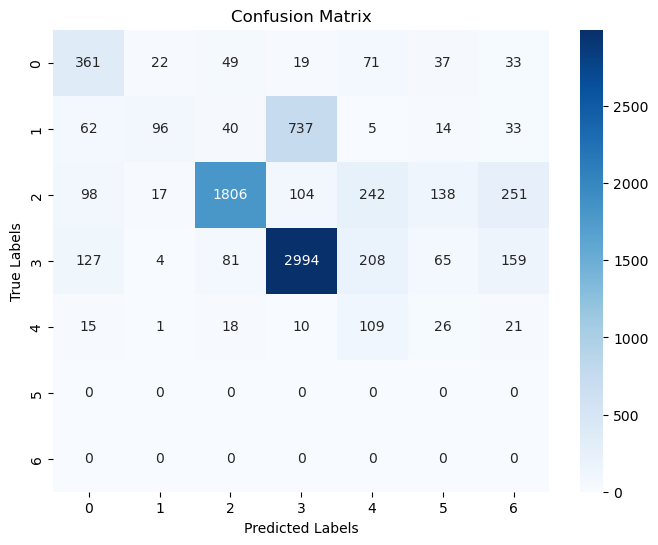

              precision    recall  f1-score   support

           0       0.54      0.61      0.58       592
           1       0.69      0.10      0.17       987
           2       0.91      0.68      0.78      2656
           3       0.77      0.82      0.80      3638
           4       0.17      0.55      0.26       200
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.66      8073
   macro avg       0.44      0.39      0.37      8073
weighted avg       0.78      0.66      0.68      8073



c:\Users\NicoloCalcagno\miniconda3\envs\UFS12DL\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NicoloCalcagno\miniconda3\envs\UFS12DL\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NicoloCalcagno\miniconda3\envs\UFS12DL\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [ ]:
# Supponiamo che x_test e y_test siano i dati di test
# Passo 1: Fai previsioni con il modello
y_pred = model.predict(x_test)

# Passo 2: Converti le probabilità in etichette (0 o 1)
y_pred_labels = (y_pred > 0.5).astype(int)  # 0.5 è la soglia standard

# Passo 3: Calcola la matrice di confusione
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_labels.argmax(axis=1))

# Passo 4: Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Passo 5: Stampa un report di classificazione
print(classification_report(y_test.argmax(axis=1), y_pred_labels.argmax(axis=1)))


#[' avanti' ' destra' ' fermo' ' indietro' ' sinistra' 'sopra' 'sotto']
